<a href="https://colab.research.google.com/github/brendanpshea/database_sql/blob/main/Database_08_IndexesTransactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Database Performance: Index, Query Plans, and Transaction Management
### Database and SQL Through Pop Culture | Brendan Shea, PhD

In this chapter, we will explore the inner workings of SQLite using a dataset from the fictional Gotham National Bank. Our focus will be on understanding how indexes, transactions, and database monitoring can optimize SQLite database performance and ensure smooth operations. We will cover the fundamentals of indexes, demonstrate their impact on query speed and database size, and discuss best practices for implementing them effectively.

Additionally, we will delve into the concept of transactions and the crucial role they play in ensuring data integrity and reliability. We will examine the ACID properties that transactions must adhere to and showcase how to work with transactions in SQLite using commands like BEGIN, COMMIT, and ROLLBACK.

Furthermore, we will emphasize the importance of database monitoring, reporting, and logging in maintaining the health and performance of SQLite databases. We will explore various monitoring techniques, discuss the types of logs generated, and highlight the tools and practices used by database administrators like ORACLE to keep databases running optimally.

Throughout the chapter, we will use practical examples and step-by-step explanations to illustrate how indexes, transactions, and monitoring can be leveraged to build robust and efficient databases. By the end, you should have a solid foundation in these key concepts and be well-equipped to apply them in your own SQLite projects.

Learning Outcomes:

1.  Understand the purpose and benefits of indexes in SQLite databases
2.  Learn how to create indexes and analyze their impact on query performance and database size
3.  Recognize situations where creating an index is advantageous and when it may not be necessary
4.  Grasp the concept of transactions and their importance in maintaining data integrity and reliability
5.  Become familiar with the ACID properties of transactions and their implications for database consistency
6.  Learn how to work with transactions in SQLite using BEGIN, COMMIT, ROLLBACK, and SAVEPOINT commands
7.  Understand the challenges of concurrent transactions and the role of locking mechanisms in managing simultaneous access to data
8.  Appreciate the significance of database monitoring, reporting, and logging in ensuring optimal performance and health of SQLite databases
9.  Gain insights into the tools and techniques used by database administrators to monitor and manage databases effectively

Keywords: SQLite, indexes, transactions, database monitoring, reporting, logging, query performance, database size, ACID properties, data integrity, reliability, concurrency, locking




## Brendan's Lecture

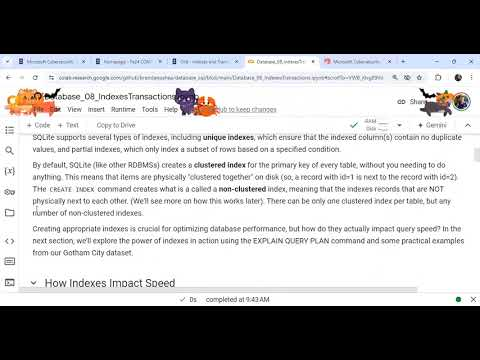

In [ ]:
# play youtube video
from IPython.display import YouTubeVideo
YouTubeVideo('DtqP72S_keA', width=800, height=450)

## Gotham National Bank Database
In this chapter, we'll be exploring the inner workings of **SQLite** using a dataset from the fictional **Gotham National Bank**. Our database, *gotham.db*, contains two tables:

1.  **Customers**: Stores customer information like name, address, and contact details.
2.  **Accounts**: Holds account-related data such as account type, balance, and creation date, with a foreign key linking to the Customers table.

Throughout this chapter, we'll use these tables to understand how **indexes** and **transactions** can optimize our SQLite database performance. We'll cover the fundamentals of indexes, demonstrate their impact on query speed and database size, and discuss best practices for implementing them effectively.

In [ ]:
!wget https://github.com/brendanpshea/database_sql/raw/main/data/gotham.db -q -nc
!pip install prettytable==0.7.2 --force-reinstall -q

%reload_ext sql
%sql sqlite:///gotham.db


## Database Schema for Gotham City Bank
Here is the database schema.

In [ ]:
%%sql
-- we are going to turn on "profiling" this lesson
PRAGMA profile = 1;
-- get table schema using sqlite master
SELECT sql FROM sqlite_master WHERE type='table';

 * sqlite:///gotham.db
Done.
Done.


sql
"CREATE TABLE Customers ( CustomerID INTEGER PRIMARY KEY AUTOINCREMENT, FirstName VARCHAR(50) NOT NULL, LastName VARCHAR(50) NOT NULL, MiddleInitial CHAR(1), Address VARCHAR(255), City VARCHAR(50), State VARCHAR(50), ZipCode VARCHAR(10), PhoneNumber VARCHAR(15), Email VARCHAR(100))"
"CREATE TABLE sqlite_sequence(name,seq)"
"CREATE TABLE Accounts ( AccountID INTEGER PRIMARY KEY AUTOINCREMENT, CustomerID INT, AccountType VARCHAR(20), Balance DECIMAL(15, 2) DEFAULT 0.00, CreatedDate DATE, FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID))"


## A Closer Look at Customers and Accounts
Now, let's take a quick look at the head of our table.

In [ ]:
%%sql
SELECT * FROM Customers LIMIT 5;

 * sqlite:///gotham.db
Done.


CustomerID,FirstName,LastName,MiddleInitial,Address,City,State,ZipCode,PhoneNumber,Email
1,Bruce,Wayne,None,1007 Mountain Drive,Gotham,NY,10001,123-456-7890,bruce.wayne@gothambank.com
2,Selina,Kyle,None,123 Cat St,Blüdhaven,NY,20002,234-567-8901,selina.kyle@gothambank.com
3,James,Gordon,None,789 Police Plaza,Gotham,NY,10003,345-678-9012,james.gordon@gothambank.com
4,Harvey,Dent,None,456 Lawyer Ave,Metropolis,NY,30004,456-789-0123,harvey.dent@gothambank.com
5,Pamela,Isley,None,369 Botanic St,Gotham,NY,10005,567-890-1234,pamela.isley@gothambank.com


In [ ]:
%%sql
SELECT * FROM Accounts LIMIT 5;

 * sqlite:///gotham.db
Done.


AccountID,CustomerID,AccountType,Balance,CreatedDate
1,1,Checking,15000,2021-01-10
2,1,Savings,75000,2021-02-11
3,2,Checking,32000,2022-03-05
4,3,Checking,86000,2023-04-15
5,4,Checking,22000,2024-05-20


## What are Indexes and How Do I Create Them?

If you've ever used a book index to quickly locate a specific topic, you already understand the basic concept of a database **index**. In the context of databases, an index is a separate data structure that allows the database engine to find and retrieve data more efficiently without having to scan the entire table.

When you create a table, SQLite (like all versions of SQL) automatically creates a unique index on the **primary key** column(s). However, you can also create additional indexes on other columns to speed up frequently used queries.

To create an index in SQL, you use the **CREATE INDEX** statement with the following syntax:

```sql
CREATE [UNIQUE] INDEX index_name
ON table_name (column1 [, column2, ...]);
```

Here's a breakdown of the components:

-   `UNIQUE`: Optional keyword that creates a unique index, ensuring no duplicate values in the indexed column(s).
-   `index_name`: The name you want to give your index.
-   `table_name`: The name of the table on which you're creating the index.
-   `column1, column2, ...`: The column(s) to be indexed. You can index multiple columns by separating them with commas.

For example, let's say we want to create an index on the *LastName* column of our *Customers* table:!

In [ ]:
%%sql
DROP INDEX IF EXISTS idx_customers_lastname;
CREATE INDEX idx_customers_lastname
ON Customers (LastName);

 * sqlite:///gotham.db
Done.
Done.


[]

This statement creates an index named idx_customer_lastname on the LastName column, allowing for faster searches based on customer last names. This will allow us to search customers by their last name more quickly.

SQLite supports several types of indexes, including **unique indexes**, which ensure that the indexed column(s) contain no duplicate values, and partial indexes, which only index a subset of rows based on a specified condition.

By default, SQLite (like other RDBMSs) creates a **clustered index** for the primary key of every table, without you needing to do anything. This means that items are physically "clustered together" on disk (so, a record with id=1 is next to the record with id=2). THe `CREATE INDEX` command creates what is a called a **non-clustered** index, meaning that the indexes records that are NOT physically next to each other. (We'll see more on how this works later). There can be only one clustered index per table, but any number of non-clustered indexes.

Creating appropriate indexes is crucial for optimizing database performance, but how do they actually impact query speed? In the next section, we'll explore the power of indexes in action using the EXPLAIN QUERY PLAN command and some practical examples from our Gotham City dataset.

## How Indexes Impact Speed

To understand the impact of indexes on query speed, we'll use the **EXPLAIN QUERY PLAN** command. This command provides insight into how SQLite executes a query, including which indexes (if any) are being used.

Let's start with an example query on our *Accounts* table that gets customers with higher than average balances

In [ ]:
%%sql
SELECT * FROM Accounts
WHERE Balance > (SELECT AVG(Balance) FROM Accounts)
ORDER BY Balance DESC
LIMIT 5;

 * sqlite:///gotham.db
Done.


AccountID,CustomerID,AccountType,Balance,CreatedDate
8136,7952,Savings,92802.15340000001,2003-01-18
3401,4699,Savings,91534.3495,2015-03-25
304,277,Savings,91283.00280000002,2021-05-08
10,8,Checking,91000,2024-10-10
5953,5751,Savings,90689.35260000001,2013-12-29


Now, let's see what the "query plan" is for this:

In [ ]:
%%sql
DROP INDEX IF EXISTS idx_accounts_balance;

EXPLAIN QUERY PLAN
SELECT * FROM Accounts
WHERE Balance > (SELECT AVG(Balance) FROM Accounts)
ORDER BY Balance DESC;

 * sqlite:///gotham.db
Done.
Done.


id,parent,notused,detail
3,0,0,SCAN Accounts
8,0,0,SCALAR SUBQUERY 1
13,8,0,SCAN Accounts
31,0,0,USE TEMP B-TREE FOR ORDER BY


If you look at the query plan here, you'll notice a few key terms that pop out:

-   **Full Table Scan**: A full table scan occurs when SQLite reads every row in a table to find the data that matches the query conditions. In this case, `SCAN Accounts` indicates that SQLite is performing a full table scan on the *Accounts* table. Full table scans can be inefficient, especially for large tables, as they require reading and checking every single row. This will change when we create an index.
-   **Scalar Subquery**: A scalar subquery is a subquery that returns a single value. In this example, `SCALAR SUBQUERY 1` refers to the subquery `(SELECT AVG(Balance) FROM Accounts)`, which calculates the average balance of all accounts. The result of this subquery is used in the main query's WHERE clause.
-   **Temporary B-Tree**: In this case, `USE TEMP B-TREE FOR ORDER BY` indicates that SQLite is using a temporary B-tree data structure to sort the result set in descending order by the *Balance* column. We'll dive deeper into B-trees in a future section.

### Impact of Indexes

If an index were created on the `Balance` column, the query execution plan would likely be different. For example, with an index on `Balance`, the execution plan might show an **index search** instead of a full table scan, resulting in faster query execution times.

To create an index on the `Balance` column, you could use the following command:

In [ ]:
%%sql
CREATE INDEX idx_accounts_balance
ON Accounts (Balance);

 * sqlite:///gotham.db
Done.


[]

Now, let's see what happens to our query plan:

In [ ]:
%%sql
EXPLAIN QUERY PLAN
SELECT * FROM Accounts
WHERE Balance > (SELECT AVG(Balance) FROM Accounts)
ORDER BY Balance DESC;

 * sqlite:///gotham.db
Done.


id,parent,notused,detail
4,0,0,SEARCH Accounts USING INDEX idx_accounts_balance (Balance>?)
8,0,0,SCALAR SUBQUERY 1
13,8,0,SCAN Accounts USING COVERING INDEX idx_accounts_balance


SQLite now uses the idx_account_balance index to search for matching rows, resulting in a more efficient query execution. Instead of scanning the entire table, it can quickly locate the relevant rows using the index.

Some new terms you'll notice:

1.  **Index Scan**: An index scan is a type of table access that uses an index to locate the required data. In this example, `SEARCH Accounts USING INDEX idx_accounts_balance (Balance>?)` means that SQLite is using the *idx_accounts_balance* index to find rows where the *Balance* is greater than the result of the scalar subquery.
2.  **Covering Index**: A covering index is an index that contains all the columns required to satisfy a query, eliminating the need for additional table lookups. In the updated plan, `SCAN Accounts USING COVERING INDEX idx_accounts_balance` indicates that the *idx_accounts_balance* index is a covering index for the subquery. This means that all the data needed to calculate the average balance is available within the index itself, making the query more efficient.


## Timing Our Queries
To further demonstrate the performance impact, let's measure the execution time of our query with and without the index. We'll be using Colab's builtin **timeit** function, which will run this query many times, and give us the average runninng time. This helps miminize the role of chance in evaluating query performance based on a single case.

In [ ]:
%%sql
-- to start, drop the index
DROP INDEX idx_accounts_balance;

 * sqlite:///gotham.db
Done.


[]

In [ ]:
%%timeit -n 1
%%sql
-- This will run this query many times
SELECT * FROM Accounts
WHERE Balance > (SELECT AVG(Balance) FROM Accounts)
ORDER BY Balance DESC;

 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
The slowest run took 4.32 times longer than the fastest. This could mean that an intermediate result is being cached.
83 ms ± 31.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%sql
-- Recreate our index
CREATE INDEX idx_accounts_balance
ON Accounts (Balance);

 * sqlite:///gotham.db
Done.


[]

In [ ]:
%%timeit -n 1
%%sql
-- Now run the query with the index
SELECT * FROM Accounts
WHERE Balance > 25000 AND  Balance < 50000;

 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
49.1 ms ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


While the specific results you get will vary each time you run the test, you should find that (on average) the index scan runs a bit faster than the full table scan. (The differences in speed will be much more pronounced with large data sets).

## How Indexes Impact Storage
Now that we've seen how indexes can significantly improve query performance, let's explore how they impact database storage. To understand this, we first need to discuss how SQLite (and many other databases) store data using a data structure called a B-tree.

### B-trees: The Backbone of Database Storage

A B-tree is a self-balancing tree data structure that maintains sorted data and allows for efficient insertion, deletion, and search operations. B-trees are particularly well-suited for databases because they optimize disk I/O operations, which is crucial when dealing with large amounts of data that cannot fit entirely in memory.

In a B-tree, each node contains multiple keys and pointers to child nodes. The keys within a node are kept in sorted order, and each key is associated with two pointers:

1.  A pointer to the child node containing keys less than the current key.
2.  A pointer to the child node containing keys greater than or equal to the current key.

This structure allows for quick traversal and search operations, as the database can navigate the tree by comparing the desired key with the keys in each node and following the appropriate pointers.

### How SQLite Uses B-trees

SQLite uses B-trees to store both tables and indexes. When you create a table, SQLite creates a B-tree where each node contains one or more rows of data. The rows within a node are sorted by the primary key, enabling efficient lookups and range queries.

For example, let's consider a simplified representation of the *Accounts* table:

```
AccountID | CustomerID | Balance
1         | 1          | 10000
2         | 1          | 5000
3         | 2          | 7500
4         | 3          | 12000`
```

In the table's B-tree, the rows would be stored in nodes, sorted by the primary key (AccountID):

```
Node 1: (1, 1, 10000) | (2, 1, 5000)
Node 2: (3, 2, 7500)  | (4, 3, 12000)
```

When you create an index on a column, SQLite generates a separate B-tree specifically for that index. The index B-tree stores the indexed column's values along with pointers to the corresponding rows in the table's B-tree.

Let's say we create an index on the *Balance* column. Then the *idx_accounts_balance* index B-tree would store the *Balance* values in sorted order, along with pointers to the corresponding rows in the *Accounts* table's B-tree:

```sql
Node 1: (5000, pointer to row 2) | (7500, pointer to row 3)
Node 2: (10000, pointer to row 1) | (12000, pointer to row 4)
```

When you query the table using the indexed column, SQLite can quickly traverse the index B-tree to find the matching values and then follow the pointers to retrieve the full row data from the table's B-tree.

By using B-trees for both tables and indexes, SQLite ensures efficient data storage and retrieval, even for large datasets. However, it's important to keep in mind that creating indexes also requires additional storage space, as each index maintains its own B-tree structure.


### Graphic: B-Trees
Here's what our B-tree for our original table might look like:


In [ ]:
import base64
from IPython.display import Image, display, HTML

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))


mm("""
graph TB
  subgraph Accounts Table B-tree - sorting by id
    N1((Node 1)) <--> |pointer to next/previous node| N2((Node 2))
    N1 --- |contains| A1[AccountID - key: 1<br>CustomerID: 1<br>Balance: 10000]
    N1 --- |contains| A2[AccountID - key: 2<br>CustomerID: 1<br>Balance: 5000]
    N2 --- |contains| A3[AccountID - key: 3<br>CustomerID: 2<br>Balance: 7500]
    N2 --- |contains| A4[AccountID - key: 4<br>CustomerID: 3<br>Balance: 12000]
  end
""")

And here's what the B-tree for the index might look like:

In [ ]:
mm("""
graph TB
  subgraph Balance Index B-tree - sorting by balance
    IN1((Node 1)) <--> | points to next/previous node | IN2((Node 2))
    IN1 --- |contains| IA2[Balance - key: 5000<br>Pointer to Account 2]
    IN1 --- |contains| IA3[Balance - key: 7500<br>Pointer to Account 3]
    IN2 --- |contains| IA1[Balance - key: 10000<br>Pointer to Account 1]
    IN2 --- |contains| IA4[Balance - key: 12000<br>Pointer to Account 4]
  end
"""
)

### Checking File Size
Because indexes require the construction of new B-trees, they require additional disk space. We can  check the file size (using Windows, Linux, etc.). Let's first first check the size our database:

In [ ]:
# In ubuntu du gives file size
!du -h gotham.db

1.9M	gotham.db


Now, let's see what happens when we an index.

In [ ]:
%%sql
DROP INDEX IF EXISTS idx_accounts_balance;
-- create an index based on first name, last name, phone
CREATE INDEX idx_customers_first_last_phone
ON Customers (FirstName, LastName, PhoneNumber);

 * sqlite:///gotham.db
Done.
Done.


[]

In [ ]:
# Now, we can check the size again
!du -h gotham.db

2.0M	gotham.db


While your results migth vary somewhat, here's what I got from running these commands:

- The database size before building the index was 1.9 mb
- The database size after building the index was 2.2 mb.

This is a large difference--over 10%--and reinforces the principle that indexes (especially ones that combine multiple columns) need to be used with care.

# SQL Indexing Guidelines: When to Create and Avoid Indexes

| Create an Index When... | Avoid Creating an Index When... |
|-------------------------|----------------------------------|
| Columns are frequently used in WHERE clauses<br>*E.g., `VillainID` in `SELECT * FROM Crimes WHERE VillainID = 123`* | Tables are small<br>*For tables with few rows, a full table scan might be faster than using an index* |
| Joining tables on specific columns<br>*E.g., `CrimeID` in `Crimes` table when joining with `Evidence` table* | Columns have low cardinality (few unique values)<br>*E.g., a `Gender` column with only 'M' and 'F' values* |
| Columns are often used in ORDER BY clauses<br>*E.g., `Date` in `SELECT * FROM Crimes ORDER BY Date DESC`* | Columns are frequently updated<br>*Indexes need to be updated when the column values change, which can slow down write operations* |
| Enforcing uniqueness is required<br>*E.g., `VillainAlias` in the `Villains` table to ensure no duplicate aliases* | Tables experience frequent large batch updates or inserts<br>*Indexes can significantly slow down these operations* |
| Querying for a range of values is common<br>*E.g., `Date` in `SELECT * FROM Crimes WHERE Date BETWEEN '2023-01-01' AND '2023-12-31'`* | Columns contain large amounts of text<br>*Indexing `TEXT` or `BLOB` columns can be inefficient and consume a lot of space* |
| Columns are used in aggregate functions with GROUP BY<br>*E.g., `District` in `SELECT District, COUNT(*) FROM Crimes GROUP BY District`* | The column is rarely used in queries<br>*If a column is only occasionally used in WHERE or JOIN clauses, an index might not be worth the overhead* |
| Foreign key columns<br>*E.g., `VillainID` in the `Crimes` table referencing `Villains` table* | Tables are very frequently updated but rarely queried<br>*In write-heavy scenarios, the cost of maintaining indexes might outweigh their benefits* |
| Columns used in DISTINCT queries<br>*E.g., `SELECT DISTINCT CrimeType FROM Crimes`* | Composite indexes with too many columns<br>*Indexes with many columns can become inefficient and hard to maintain* |
| Covering index opportunities exist<br>*When all columns in a query can be satisfied by an index without accessing the table* | The database is already over-indexed<br>*Too many indexes can lead to performance degradation and increased storage use* |
| Improving performance of full-text searches<br>*E.g., creating a full-text index on `Description` in a `CrimeReports` table* | Columns contain primarily NULL values<br>*Indexing columns with many NULL values might not provide significant performance benefits* |

**Note**: Always test the performance impact of indexes in your specific database environment. The effectiveness of an index can vary based on factors such as data distribution, query patterns, and the specific database management system being used.

## Introduction to Transactions

In the world of databases, much like in the bustling financial district of Gotham City, many operations happen simultaneously. Imagine the chaos if every bank transaction in Gotham wasn't carefully managed - it would be a playground for villains! This is where database transactions come into play. A **transaction** is a sequence of one or more database operations that are treated as a single unit of work. These operations could be inserting, updating, or deleting data. The key characteristic of a transaction is that it's all-or-nothing: either all the operations within the transaction are completed successfully, or none of them are.

Let's consider a scenario at Gotham City Bank. Bruce Wayne wants to transfer money from his personal account to Wayne Enterprises' account. This seemingly simple transfer actually involves multiple steps: first, the money is deducted from Bruce's account, and then it's added to the company's account. If something goes wrong halfway through - perhaps due to a system crash or The Riddler's latest cyber attack - we wouldn't want Bruce's money to vanish into thin air. This is why we use transactions.

Transactions are crucial in maintaining the integrity and consistency of our database. They ensure that our data remains accurate even when multiple operations are happening concurrently or when unexpected errors occur. In our Gotham City Bank example, a transaction would guarantee that either both steps of the money transfer are completed, or neither is - the money can't be deducted from Bruce's account without being added to Wayne Enterprises', or vice versa.

### ACID Properties Overview

When discussing database transactions, you'll often hear the term **ACID**. This isn't a reference to Joker's favorite chemical weapons, but rather an acronym that stands for four critical properties of transactions: **Atomicity**, **Consistency**, **Isolation**, and **Durability**. These properties ensure that database transactions are processed reliably and maintain data integrity, even in the face of errors, system failures, or concurrent access.

Let's break down what each of these properties means:

1. **Atomicity** ensures that a transaction is treated as a single, indivisible unit. Either all operations in the transaction are completed successfully, or none are.
2. **Consistency** guarantees that a transaction brings the database from one valid state to another, maintaining all predefined rules and constraints.
3. **Isolation** ensures that concurrent execution of transactions leaves the database in the same state as if the transactions were executed sequentially.
4. **Durability**  means that once a transaction is committed, it remains so, even in the event of power loss, crashes, or errors.

Understanding ACID properties is crucial for anyone working with databases, as they form the foundation of reliable data management. They're like the principles Batman follows to keep Gotham safe - non-negotiable rules that maintain order in the face of chaos.

In the following sections, we'll dive deeper into each of these properties, exploring how they work and why they're important. We'll see how they apply in various scenarios in Gotham City, from managing the Batcave's high-tech systems to keeping track of Arkham Asylum's ever-rotating cast of inmates. By the end, you'll have a solid grasp of how transactions and ACID properties help maintain order in the complex world of databases.

### Atomicity

**Atomicity** is the first pillar of ACID properties, and it's a concept as uncompromising as Batman's commitment to justice. In database terms, atomicity guarantees that a transaction is treated as a single, indivisible unit of work. This means that all operations within a transaction must be completed successfully, or none of them will be. There's no middle ground - it's all or nothing.

Let's illustrate this with a scenario from Gotham City. Imagine Bruce Wayne is updating the Batcave's inventory system. He's adding a new Batmobile while simultaneously removing an older model. This process involves two operations:

1. Insert a record for the new Batmobile
2. Delete the record of the old Batmobile

Atomicity ensures that either both of these operations succeed, or neither does. If something goes wrong halfway through - perhaps a power outage caused by one of Mr. Freeze's attacks - the database will revert to its original state. We won't end up in a situation where we've added the new Batmobile but failed to remove the old one, or vice versa.

This "all-or-nothing" approach is crucial for maintaining data integrity. Without atomicity, we could end up with inconsistent data that doesn't reflect reality. In our Batcave example, an inventory that shows two Batmobiles when there's really only one could lead to confusion and inefficiency in Batman's operations.

Implementing atomicity involves using **commits** and **rollbacks**. When a transaction completes successfully, we **commit** it, making all of its changes permanent. If any part of the transaction fails, we perform a **rollback**, undoing any changes made by the transaction and returning the database to its previous consistent state.

In standard SQL, you can implement atomic transactions using the following basic syntax:

```sql
BEGIN TRANSACTION;
-- Your SQL operations here
COMMIT;
```

If an error occurs, you can use `ROLLBACK` instead of `COMMIT` to undo the changes:

```sql
BEGIN TRANSACTION;
-- Your SQL operations here
-- If an error occurs:
ROLLBACK;
```

Understanding and properly implementing atomicity is crucial for maintaining the integrity of your database, ensuring that complex operations either complete fully or don't happen at all.

In [ ]:
mm("""
flowchart TD
    subgraph Transaction_Process
        A[Starting State A<br>Consistent State of Database] --> B[BEGIN TRANSACTION]
        B --> C[Perform Operations]
        C --> D{Error Occurred?}
        D -- No --> E[COMMIT TRANSACTION<br>Write operations to disk]
        D -- Yes --> F[ROLLBACK<br>Undo all operations]
        F --> A
        E -->G[Ending State B<br>Consistent State of Database]
    end
""")

### Consistency

**Consistency**, the second ACID property, is all about maintaining the database in a valid state. It ensures that a transaction can only bring the database from one valid state to another, adhering to all predefined rules and constraints. This property is like the laws and regulations that keep Gotham City functioning - they ensure that no matter what changes occur, the city (or in our case, the database) remains in a valid, predictable state.

In database terms, consistency means that all data written to the database must adhere to all defined rules, including constraints, cascades, and triggers. These rules might include:

- Data types (e.g., you can't store text in a numeric field)
- Unique constraints
- Foreign key constraints
- Check constraints that enforce specific business rules

Let's consider an example from the Gotham City Police Department (GCPD). They maintain a database of known super-villains, including which cell they're assigned to in Arkham Asylum. The database has a rule that each cell can only hold one villain at a time. Consistency ensures that no transaction can violate this rule.

Imagine Commissioner Gordon is updating the database after capturing both The Joker and The Penguin in a single night. Here's what the transaction might look like:

1. Assign The Joker to Cell A1
2. Assign The Penguin to Cell B2
3. Update the status of both villains to "Incarcerated"

Consistency guarantees that if any part of this transaction would violate the "one villain per cell" rule (for example, if Cell A1 was already occupied), the entire transaction would fail. The database would remain in its previous consistent state, rather than ending up in an invalid state with two villains assigned to the same cell.

SQL provides various mechanisms to enforce consistency, some of which we have discussed earlier:

1. **Constraints**: These are rules defined on columns or tables. For example:

```sql
CREATE TABLE Villains (
    ID INTEGER PRIMARY KEY,
    Name TEXT NOT NULL,
    Cell TEXT UNIQUE,
    Status TEXT CHECK (Status IN ('At Large', 'Incarcerated'))
);
```

2. **Triggers**: These are automated actions that occur in response to certain database events. For example:

```sql
CREATE TRIGGER check_cell_occupancy
BEFORE INSERT ON Villains
FOR EACH ROW
BEGIN
    SELECT CASE
        WHEN (SELECT COUNT(*) FROM Villains WHERE Cell = NEW.Cell) > 0
        THEN RAISE(ABORT, 'Cell already occupied')
    END;
END;
```

3. **Transactions**: By grouping operations together in a transaction, you ensure that either all consistency rules are met, or none of the operations are performed.

Maintaining consistency is crucial for ensuring that your database always reflects a valid real-world scenario. It prevents contradictions and impossibilities in your data, much like how the laws of Gotham prevent (or at least try to prevent) chaos from taking over the city.

### Isolation

**Isolation**, the third ACID property, ensures that concurrent execution of transactions leaves the database in the same state as if the transactions were executed sequentially. In other words, each transaction should feel like it's the only one interacting with the database, even when multiple transactions are running simultaneously. This property is crucial in multi-user database systems, much like how Batman needs to isolate and handle multiple crimes occurring simultaneously in Gotham without letting them interfere with each other.

Imagine a scenario where both Bruce Wayne and Alfred are accessing the Batcomputer's database at the same time. Bruce is updating the Batmobile's fuel levels after a night of patrol, while Alfred is logging new equipment arrivals. Isolation ensures that these two operations don't interfere with each other, preventing scenarios like lost updates or dirty reads.

**Concurrency** in databases refers to the ability of the database management system (DBMS) to handle multiple transactions simultaneously. While concurrency can greatly improve performance and responsiveness, it also introduces challenges. For instance, if two villains, let's say The Riddler and The Penguin, try to access Wayne Enterprises' financial records simultaneously, we need to ensure they don't interfere with each other's operations or see partially updated data.

To manage concurrency and maintain isolation, databases use **locks**. A **lock** is a mechanism that restricts access to a piece of data. There are typically two types of locks:

1. **Shared locks ("read locks")**: Allow multiple transactions to read data simultaneously.
2. **Exclusive locks ("write locks")**: Restrict access to a single transaction for write operations.

For example, when Bruce is updating the Batmobile's fuel levels, the database might place an exclusive lock on that record, preventing Alfred from making changes to the same data until Bruce's transaction is complete.

However, excessive locking can lead to performance issues and, in some cases, **deadlocks**. A **deadlock** occurs when two or more transactions are waiting for each other to release locks, resulting in a standoff. Imagine Batman and Catwoman each holding a piece of evidence the other needs - neither can proceed without the other's item, but neither is willing to give up their own first. Databases have mechanisms to detect and resolve deadlocks, often by choosing one transaction to roll back.

Full-featured client-server databases (such as PostgreSQL, MySQL, ORacle, etc.) offer various **isolation levels** that provide different trade-offs between consistency and performance:

* **Read Uncommitted.** Transactions can see changes made by other transactions before they are finalized, which can lead to inconsistent data.
* **Read Committed.**  Transactions can only see changes made by other transactions after they are finalized, reducing the risk of inconsistent data.
* **Repeatable Read.**  Once a transaction reads data, it will see the same data if it reads it again, even if other transactions make changes in the meantime.
* **Serializable.** Transactions are completely isolated from each other, as if they are happening one after the other, ensuring the highest level of data consistency.

Each level provides stronger guarantees but potentially at the cost of reduced concurrency. SQLite, by default, operates at the Serializable isolation level.

Understanding and properly implementing isolation is crucial for maintaining data integrity in multi-user environments, ensuring that concurrent operations don't lead to data inconsistencies or conflicts.

### Durability

**Durability**, the final ACID property, guarantees that once a transaction has been committed, it will remain so, even in the event of a system failure, power outage, or crash. This property ensures that your data persists, much like how the legacy of Batman endures through all of Gotham's trials and tribulations.

In database terms, durability means that all completed transactions are recorded in non-volatile memory. Once the database confirms that a transaction has been committed, that data should be safe, even if the server crashes immediately afterward.

Let's consider a scenario at Arkham Asylum. Dr. Harleen Quinzel (before her transformation into Harley Quinn) is updating patient records. She's just finished noting that The Joker has been administered his daily medication - a crucial piece of information for maintaining order in the asylum. Durability ensures that even if there's a sudden power outage (perhaps caused by Electrocutioner), this update will not be lost.

Both SQLite and PostgreSQL implement durability, but they do so in slightly different ways:

1. **SQLite** uses a write-ahead log (WAL) by default. Before changes are made to the main database file, they are written to this log. If a crash occurs during a transaction, SQLite can recover the changes from the WAL.

2. **PostgreSQL** uses a write-ahead log as well, but it also provides more advanced features for ensuring durability, such as:
   - Asynchronous Commit: Allows for faster performance at the risk of losing the latest transactions in case of a crash.
   - Synchronous Replication: Ensures that data is written to multiple servers before considering a transaction complete.

To ensure durability, databases use **transaction logs**. These logs record all database modifications. In the event of a system failure, the database can use these logs to recover to a consistent state. It's like Batman's case files - even if the Batcave is compromised, he can reconstruct his investigations from these detailed records.

Here's a simple example of a durable transaction in SQL:

```sql
BEGIN;
UPDATE Inmates
SET MedicationAdministered = TRUE
WHERE Name = 'Joker' AND Date = CURRENT_DATE;
COMMIT;
```

Once this COMMIT statement successfully completes, the database guarantees that this update will persist, even in the face of subsequent system failures.

While durability provides strong guarantees, it's important to note that it can impact performance. Writing every change to disk immediately can slow down transaction processing. Database administrators often need to balance durability requirements with performance needs, much like how Batman must balance his desire for justice with the practical limitations of his resources.

Proper backup strategies are also crucial for maintaining durability over the long term. Regular backups ensure that even in catastrophic scenarios, your data can be recovered. It's the database equivalent of Batman's contingency plans - always prepared for the worst-case scenario.

Understanding durability helps ensure that critical data is never lost, maintaining the integrity and reliability of your database system even in the face of unexpected events or system failures.

### Deadlocks

A **deadlock** occurs when two or more transactions are waiting for each other to release resources, resulting in a standoff where none can proceed. It's like a situation where Batman and Catwoman are each holding a piece of evidence that the other needs, and neither is willing to give up their item first.

Deadlocks typically involve at least two transactions and two resources. For example:
1. Transaction A holds a lock on Resource X and requests a lock on Resource Y.
2. Simultaneously, Transaction B holds a lock on Resource Y and requests a lock on Resource X.

Both transactions are now stuck, waiting for a resource that the other holds.

To prevent deadlocks, database systems use various strategies:
- **Timeout mechanisms**: Transactions are automatically rolled back if they wait too long for a resource.
- **Deadlock detection**: The system actively looks for deadlock cycles and resolves them by choosing a "victim" transaction to roll back.
- **Deadlock prevention**: This involves techniques like always acquiring resources in a specific order.

Here's an example of how you might handle a deadlock situation in your code:

```sql
BEGIN;
-- Attempt to acquire locks with a timeout
SET LOCAL lock_timeout = '5s';
-- Your transaction operations here
COMMIT;
```

If a deadlock occurs, this transaction will be automatically rolled back after 5 seconds, allowing other transactions to proceed.

### Performance Considerations

While transactions are crucial for data integrity, they can impact database performance if not used judiciously. Each transaction requires overhead for managing locks, logging changes, and ensuring ACID properties.

Some key performance considerations include:
- **Transaction size**: Smaller, focused transactions generally perform better than large, complex ones.
- **Indexing**: Proper indexing can significantly speed up the operations within a transaction.
- **Isolation level**: Higher isolation levels provide stronger guarantees but may reduce concurrency.

For instance, in managing Gotham City's traffic system, you might use different transaction strategies for routine updates versus emergency situations:

```sql
-- Routine update: lower isolation, shorter duration
BEGIN;
SET TRANSACTION ISOLATION LEVEL READ COMMITTED;
UPDATE TrafficLights SET State = 'Green' WHERE Intersection = 'Park Row';
COMMIT;

-- Emergency situation: highest isolation, possibly longer duration
BEGIN;
SET TRANSACTION ISOLATION LEVEL SERIALIZABLE;
UPDATE TrafficLights SET State = 'Red' WHERE District = 'Downtown';
UPDATE EmergencyRoutes SET Status = 'Active' WHERE Type = 'Fire';
COMMIT;
```

### Error Handling in Transactions

Proper error handling is crucial in transactional systems. It's like Batman's contingency plans - you hope you won't need them, but they're essential when things go wrong.

In SQL, you can use TRY-CATCH blocks (in systems that support them) or check for error conditions and roll back manually:

```sql
BEGIN;
SAVEPOINT my_savepoint;

-- Attempt the transaction
UPDATE BatcaveInventory SET Quantity = Quantity - 1 WHERE Item = 'Batarang';

-- Check if the update was successful
IF (SELECT Quantity FROM BatcaveInventory WHERE Item = 'Batarang') < 0 THEN
    -- Rollback to the savepoint if we've gone into negative inventory
    ROLLBACK TO my_savepoint;
    RAISE EXCEPTION 'Not enough Batarangs in inventory';
ELSE
    -- Commit if everything is okay
    COMMIT;
END IF;
```

This approach allows you to handle errors gracefully, maintaining data consistency even when unexpected situations arise.

## NoSQL Case Study: Harley's Havoc

After her latest split with the Joker, Harley Quinn decides to launch "Harley's Havoc" - a marketplace for circus equipment, practical joke supplies, and questionably-obtained collectibles. Given the chaotic nature of her business and the need to handle thousands of simultaneous users during her infamous flash sales, she needs a database that can scale horizontally and handle rapid writes. She decides to use **MongoDB**, a widely used **NoSQL** database.

MongoDB stores data in BSON (Binary JSON) format. Here's how a typical product listing in Harley's store might look:

```javascript
{
  "_id": ObjectId("5f7d3a2e9d3b2c1234567890"),
  "name": "Authentic Trick Mallet",
  "description": "Guaranteed to make that *BONK* sound!",
  "price": 49.99,
  "stock": 42,
  "categories": ["weapons", "classics", "crowd-favorites"],
  "reviews": [
    {
      "user": "PoisonIvy",
      "rating": 5,
      "comment": "Perfect for bopping Batman!"
    },
    {
      "user": "CatWoman",
      "rating": 4,
      "comment": "Shipping was slow but worth the wait"
    }
  ],
  "variants": {
    "colors": ["red", "black", "purple"],
    "sizes": ["standard", "oversized"]
  }
}
```

Notice how flexible this structure is - we can nest arrays and objects, and each product document can have different fields. This flexibility is one of MongoDB's key advantages over rigid SQL schemas.

### Scaling Out: Why Harley Chose MongoDB

Unlike Gotham City Bank's traditional SQL database, MongoDB can easily distribute data across multiple machines using **sharding**. When Harley's flash sales cause traffic spikes, the system can handle it by:

1. Automatically distributing data across multiple shards
2. Routing queries to appropriate shards
3. Balancing data as new shards are added

```javascript
// Example of how MongoDB might shard Harley's collection
db.createCollection("products")
sh.shardCollection("harleysHavoc.products",
  { "categories": "hashed" }) // Shard by category for even distribution
```

#### The Move from ACID to BASE
To achieve this scalability, MongoDB adopts **BASE (Basically Available, Soft state, Eventually consistent)** instead of ACID properties. Here's what this means for Harley's business:

**Advantages:**
- Can handle thousands of simultaneous writes during flash sales
- New product categories can be added without schema changes
- Queries can be distributed across multiple servers
- Quick recovery if a server goes down (high availability)

**Trade-offs:**
- No true multi-document transactions (until recent versions, which impose a speed cost)
- Eventual consistency means inventory counts might be temporarily incorrect
- Complex queries across multiple collections are more challenging
- No built-in referential integrity

### Why This Would Be Disastrous for Gotham City Bank

Let's contrast this with banking requirements:

1. **Atomicity**: When the Joker transfers money between accounts, it must either completely succeed or completely fail. There's no room for "eventual consistency" when dealing with money.

2. **Consistency**: Account balances must be accurate at all times. The bank can't tell Batman his account balance is \$10,000,000 on one server and \$9,000,000 on another.

3. **Isolation**: If Penguin and Riddler are both trying to withdraw from the same account, their transactions must be properly serialized to prevent double-spending.

4. **Durability**: Once a transaction is confirmed, it must survive any system crashes. The bank can't tell Two-Face "sorry, that deposit might have gotten lost during a server failover."

### Best of Both Worlds: Hybrid Approaches
Modern applications often use both SQL and NoSQL databases. For Harley's business, she could:
- Use MongoDB for product catalog and user sessions
- Use PostgreSQL for payment processing and critical inventory tracking
- Implement application-level consistency checks for critical operations

Finally, it is important to note that MongoDB has gotten more "relational" over the years (for example, providing better support for transactions) even while popular RDBMSs (Postgres, Oracle, SQL Server) have provided native support for JSON and sharding.

# A Day in the Life of a Database Administrator

Meet **Barbara Gordon**, affectionately known as **"Oracle"** by her colleagues. As the chief Database Administrator (DBA) for the Gotham City Police Department (GCPD), Barbara plays a crucial role in managing the vast amounts of data that flow through the department daily. From tracking criminal records to managing real-time incident reports, the GCPD's database systems are the backbone of Gotham's law enforcement operations. This section provides an insight into Barbara's typical day, highlighting key concepts of database monitoring, reporting, and performance metrics as exemplified by our database logs.

---

## Morning: Proactive Monitoring

### 8:00 AM - Starting the Day with System Checks

Barbara begins her day by performing **proactive monitoring** of the GCPD's database systems. She logs into the system to review overnight activities and ensure everything is running smoothly.

- She checks **system performance metrics** such as **CPU usage**, **memory consumption**, and **disk I/O statistics** to confirm that the servers are operating within optimal parameters.
- Scanning the **error logs**, Barbara looks for any critical issues like **unique constraint violations** (`"ORA-00001"`) or **connection failures** that might indicate underlying problems.
- Verifying that **automated backups** ran successfully, she ensures that data integrity is maintained and that the system is prepared for disaster recovery if necessary.

Understanding the importance of **monitoring**, Barbara knows that continuously observing the database helps detect performance issues, errors, and security threats before they escalate.

---

## Mid-Morning: Analyzing Performance Reports

### 10:00 AM - Reviewing Query Performance

Barbara receives reports indicating that some detectives are experiencing slow response times when querying the criminal records database. She dives into the **query logs** to identify any **slow-running queries**.

By examining queries with high **execution times**, she discovers that certain complex join operations are taking longer than expected. Recognizing an opportunity for **performance optimization**, Barbara plans to:

- Add appropriate **indexes** to improve data retrieval speeds.
- Rewrite inefficient **SQL statements** to enhance their efficiency.

She understands that **reporting** plays a vital role in providing insights into database performance over time. By analyzing these reports, she can identify patterns and make informed decisions to optimize the system.

---

## Afternoon: Addressing Security Concerns

### 1:00 PM - Investigating Unauthorized Access Attempts

An alert notifies Barbara of multiple failed login attempts from an unknown IP address. Recognizing the potential security threat, she examines the **connection logs** to investigate.

By querying the logs for suspicious activity from the specific IP, she confirms unauthorized access attempts. Barbara promptly informs the security team and takes action to **block the IP address**, preventing any potential breaches.

This situation highlights the importance of **security monitoring** in database administration. By keeping track of **access logs** and detecting anomalies, Barbara helps protect the database from threats and ensures compliance with security policies.

---

## Late Afternoon: Managing Schema Changes

### 3:00 PM - Implementing New Features

A new feature requires adding a table to store information about emerging threats. Barbara carefully plans the **schema change**, understanding the impact it may have on existing operations.

She applies the changes by executing the necessary **Data Definition Language (DDL) statements**, such as:

```sql
CREATE TABLE emerging_threats (
  id INTEGER PRIMARY KEY,
  description TEXT,
  level INTEGER,
  reported_at DATETIME
);
```

After implementing the change, she records the schema modification for future reference and auditing. Managing **schema changes** is a critical aspect of her role, ensuring that the database structure evolves to meet new requirements without disrupting current functionalities.

---

## Evening: Reflecting and Preparing

### 5:00 PM - Reviewing the Day's Activities

As the day winds down, Barbara reviews the day's events. She summarizes key activities, including performance optimizations, security incidents, and schema changes.

Preparing detailed **reports** for stakeholders, she translates technical metrics into understandable insights. This practice keeps everyone informed and aids in strategic planning.

---

## Common Database Performance Metrics

Understanding database performance requires familiarity with various metrics. Below is a table of common metrics that Barbara monitors regularly:

| Metric Name             | Definition                                                                                   |
|-------------------------|----------------------------------------------------------------------------------------------|
| **CPU Usage (%)**       | The percentage of CPU resources utilized by the database processes.                          |
| **Memory Consumption**  | The amount of RAM used by the database system for operations and caching.                    |
| **Disk I/O (MB/s)**     | The rate of data read from and written to disk storage per second.                          |
| **Query Execution Time (ms)** | The time taken to execute a SQL query from start to finish.                        |
| **Transactions Per Second (TPS)** | The number of transactions the database processes each second.                |
| **Connections**         | The number of active connections to the database at a given time.                            |
| **Cache Hit Ratio (%)** | The percentage of database reads that are served from cache rather than disk.                |
| **Lock Wait Time (ms)** | The time processes wait to acquire locks on database resources.                              |
| **Deadlocks**           | The number of times processes are stuck in a deadlock situation and need to be resolved.      |
| **Network Latency (ms)**| The time it takes for data to travel between the database server and clients over the network.|

Monitoring these metrics allows Barbara to ensure that the database operates efficiently and to identify areas where performance can be improved.

---

Barbara Gordon's day exemplifies the multifaceted role of a Database Administrator. Through diligent monitoring of **performance metrics**, proactive problem-solving, and effective communication, she ensures that the GCPD's databases are secure, efficient, and reliable.

By understanding and utilizing key concepts such as **proactive monitoring**, **performance optimization**, **security monitoring**, and **schema change management**, Barbara keeps the database systems running smoothly, supporting the critical work of Gotham's law enforcement.

As we delve into the database logs in the following sections, we'll explore these technical aspects in more detail. Barbara's experiences provide context for why these logs are vital and how they contribute to effective database administration.

## Lab: Querying Database Logs

The `dbms_logs.db` database is a SQLite database that contains a single table named `Logs`. This table stores various types of database management system (DBMS) log entries in JSON format. Each log entry represents an event such as a query execution, transaction, error, connection, or schema change.

### Table Structure: Logs

| Column Name | Data Type | Description                                     |
|-------------|-----------|-------------------------------------------------|
| `id`        | INTEGER   | Unique identifier for each log entry. Auto-incremented primary key. |
| `timestamp` | DATETIME  | The date and time when the log entry was created. Defaults to the current timestamp if not provided. |
| `data`      | JSON      | A JSON object containing detailed information about the log entry. |

### Column Details (for `Logs` table)

### 1. `id` (INTEGER)

- **Description:** Unique identifier for each log entry.
- **Attributes:** Primary Key, Auto-incremented.
- **Example Values:** `1`, `2`, `3`, ...

### 2. `timestamp` (DATETIME)

- **Description:** The date and time when the log entry was created.
- **Format:** ISO 8601 format (`YYYY-MM-DD HH:MM:SS`).
- **Example Values:** `2023-09-22 15:30:00`, `2023-09-21 10:15:30`.

### 3. `data` (JSON)

- **Description:** A JSON object containing the details of the log entry.
- **Structure:** Varies depending on the `type` of log entry.
- **Possible Log Entry Types:** `query_execution`, `transaction`, `error`, `connection`, `schema_change`.

### Log Entry Types and Their Fields

The `data` column's JSON object includes a `type` field that determines the structure of the rest of the fields. Below are the possible log entry types and their corresponding fields.

### 1. **Query Execution Log**

**Type:** `"query_execution"`

**Description:** Records details about SQL query executions.

#### Fields

| Field Name          | Data Type | Description                                   | Example Values                              |
|---------------------|-----------|-----------------------------------------------|---------------------------------------------|
| `type`              | STRING    | The type of log entry (`"query_execution"`).  | `"query_execution"`                         |
| `query_id`          | STRING    | Unique identifier for the query.              | `"Q-1234"`                                  |
| `sql`               | STRING    | The SQL statement executed.                   | `"SELECT * FROM users WHERE id = 1"`        |
| `execution_time_ms` | FLOAT     | Time taken to execute the query in milliseconds. | `150.25`                                    |
| `rows_affected`     | INTEGER   | Number of rows affected by the query.         | `0`, `10`, `100`                            |
| `user`              | STRING    | Username of the person who executed the query. | `"user_42"`                                 |
| `timestamp`         | STRING    | Timestamp when the log entry was created.     | `"2023-09-22T15:30:00"`                     |


### 2. **Transaction Log**

**Type:** `"transaction"`

**Description:** Logs information about database transactions.

#### Fields

| Field Name       | Data Type | Description                                      | Example Values          |
|------------------|-----------|--------------------------------------------------|-------------------------|
| `type`           | STRING    | The type of log entry (`"transaction"`).         | `"transaction"`         |
| `transaction_id` | STRING    | Unique identifier for the transaction.           | `"T-54321"`             |
| `operation`      | STRING    | Transaction operation (`"BEGIN"`, `"COMMIT"`, `"ROLLBACK"`). | `"BEGIN"`              |
| `duration_ms`    | FLOAT     | Duration of the transaction in milliseconds.     | `200.5`                 |
| `user`           | STRING    | Username involved in the transaction.            | `"user_17"`             |
| `timestamp`      | STRING    | Timestamp when the log entry was created.        | `"2023-09-21T10:15:30"` |


### 3. **Error Log**

**Type:** `"error"`

**Description:** Contains details about errors that occurred during database operations.

#### Fields

| Field Name   | Data Type | Description                                   | Example Values                                  |
|--------------|-----------|-----------------------------------------------|-------------------------------------------------|
| `type`       | STRING    | The type of log entry (`"error"`).            | `"error"`                                       |
| `error_code` | STRING    | Error code associated with the error.         | `"ORA-00001"`, `"PG-00001"`, `"SQLSTATE 23000"` |
| `message`    | STRING    | Descriptive error message.                    | `"Unique constraint violated"`                  |
| `query_id`   | STRING    | ID of the query that caused the error.        | `"Q-5678"`                                      |
| `sql`        | STRING    | The SQL statement that caused the error.      | `"INSERT INTO users (id, name) VALUES (1, 'Alice')"` |
| `stack_trace`| STRING    | Stack trace where the error occurred.         | `"Error at line 45 in procedure proc_insert..."` |
| `timestamp`  | STRING    | Timestamp when the log entry was created.     | `"2023-09-20T08:45:00"`                         |


### 4. **Connection Log**

**Type:** `"connection"`

**Description:** Logs connection events to the database.

#### Fields

| Field Name    | Data Type | Description                                   | Example Values               |
|---------------|-----------|-----------------------------------------------|------------------------------|
| `type`        | STRING    | The type of log entry (`"connection"`).       | `"connection"`               |
| `action`      | STRING    | Connection action (`"CONNECT"` or `"DISCONNECT"`). | `"CONNECT"`, `"DISCONNECT"` |
| `user`        | STRING    | Username of the person connecting/disconnecting. | `"user_25"`                |
| `ip_address`  | STRING    | IP address of the client machine.             | `"192.168.1.10"`             |
| `duration_ms` | FLOAT     | *(Optional)* Duration of the connection in milliseconds. Present only for `"DISCONNECT"` actions. | `5000.75` |
| `timestamp`   | STRING    | Timestamp when the log entry was created.     | `"2023-09-19T14:20:00"`      |

---

### 5. **Schema Change Log**

**Type:** `"schema_change"`

**Description:** Records changes made to the database schema.

#### Fields

| Field Name     | Data Type | Description                                   | Example Values                  |
|----------------|-----------|-----------------------------------------------|---------------------------------|
| `type`         | STRING    | The type of log entry (`"schema_change"`).    | `"schema_change"`               |
| `object_type`  | STRING    | Type of database object affected.             | `"TABLE"`, `"INDEX"`, `"VIEW"`  |
| `object_name`  | STRING    | Name of the database object affected.         | `"products_42"`                 |
| `action`       | STRING    | Schema action performed (`"CREATE"`, `"ALTER"`, `"DROP"`). | `"CREATE"`            |
| `ddl_statement`| STRING    | The DDL statement executed.                   | `"CREATE TABLE products_42 (...)"` |
| `user`         | STRING    | Username of the person who made the change.   | `"user_33"`                     |
| `timestamp`    | STRING    | Timestamp when the log entry was created.     | `"2023-09-18T11:00:00"`         |



### Querying the Database

To extract information from the `Logs` table, you can use SQLite's JSON functions. Below are some sample queries to help you get started.
- **`json_extract(json, path)`**: Extracts a value from a JSON string.
- **`json_type(json, path)`**: Returns the type of the value at the specified path.

Some sample queries:


### Sample Queries

In [ ]:
!wget https://github.com/brendanpshea/database_sql/raw/main/data/dbms_logs.db -q -nc
%reload_ext sql
%sql sqlite:///dbms_logs.db

In [ ]:
%%sql
--Retrieve all query execution logs
SELECT
  id,
  timestamp,
  json_extract(data, '$.query_id') AS query_id,
  json_extract(data, '$.sql') AS sql_statement,
  json_extract(data, '$.execution_time_ms') AS execution_time_ms,
  json_extract(data, '$.rows_affected') AS rows_affected,
  json_extract(data, '$.user') AS user
FROM Logs
WHERE json_extract(data, '$.type') = 'query_execution'
LIMIT 5

 * sqlite:///dbms_logs.db
   sqlite:///gotham.db
Done.


id,timestamp,query_id,sql_statement,execution_time_ms,rows_affected,user
5,2024-09-04T09:17:09.045414,Q-8305,SELECT * FROM users WHERE last_login > '2023-10-30 19:52:34',199.2,685,user_64
13,2024-09-19T16:28:24.045934,Q-8385,DELETE FROM expired_sessions WHERE expiry_date < '2023-12-29 21:37:18',466.24,689,user_19
16,2024-08-31T02:47:26.046207,Q-6789,DELETE FROM expired_sessions WHERE expiry_date < '2024-08-16 16:24:21',32.7,152,user_66
37,2024-09-13T00:39:58.048539,Q-4412,"SELECT product_id, SUM(quantity) FROM sales WHERE sale_date = '2024-03-20 16:45:59' GROUP BY product_id",4083.9,957,user_93
38,2024-09-04T06:55:44.048599,Q-2576,UPDATE accounts SET balance = balance + -10.58 WHERE account_id = 2758,2556.38,850,user_6


In [ ]:
%%sql
--Find errors witha specific code
SELECT
  id,
  timestamp,
  json_extract(data, '$.error_code') AS error_code,
  json_extract(data, '$.message') AS message,
  json_extract(data, '$.query_id') AS query_id,
  json_extract(data, '$.sql') AS sql_statement
FROM Logs
WHERE json_extract(data, '$.type') = 'error'
  AND json_extract(data, '$.error_code') = 'ORA-00001'
LIMIT 10

 * sqlite:///dbms_logs.db
   sqlite:///gotham.db
Done.


id,timestamp,error_code,message,query_id,sql_statement
61,2024-09-03T22:28:21.050081,ORA-00001,Unique constraint violated,Q-5291,DELETE FROM expired_sessions WHERE expiry_date < '2024-03-11 12:26:58'
351,2024-08-26T02:53:10.069339,ORA-00001,Unique constraint violated,Q-4517,DELETE FROM expired_sessions WHERE expiry_date < '2024-08-01 03:17:31'
439,2024-08-30T12:53:03.073980,ORA-00001,Unique constraint violated,Q-5594,UPDATE products SET stock = stock - 1 WHERE id = 558
461,2024-09-09T19:29:09.074835,ORA-00001,Unique constraint violated,Q-5940,DELETE FROM expired_sessions WHERE expiry_date < '2024-04-08 11:24:18'
466,2024-09-02T13:26:31.075155,ORA-00001,Unique constraint violated,Q-6007,SELECT * FROM users WHERE last_login > '2024-01-02 10:50:11'
481,2024-09-02T23:14:14.075941,ORA-00001,Unique constraint violated,Q-4459,UPDATE products SET stock = stock - 1 WHERE id = 480
505,2024-09-12T07:40:03.656038,ORA-00001,Unique constraint violated,Q-8420,"INSERT INTO orders (user_id, product_id, quantity) VALUES (817, 296, 9)"
530,2024-09-05T19:54:18.657065,ORA-00001,Unique constraint violated,Q-8690,SELECT * FROM users WHERE last_login > '2023-11-30 05:32:33'
562,2024-09-20T13:33:16.658097,ORA-00001,Unique constraint violated,Q-1629,SELECT COUNT(*) FROM orders WHERE order_date BETWEEN '2023-12-24 12:34:35' AND '2024-07-18 18:15:29'
688,2024-08-28T01:58:39.662287,ORA-00001,Unique constraint violated,Q-1873,SELECT COUNT(*) FROM orders WHERE order_date BETWEEN '2024-06-30 13:23:59' AND '2024-09-20 01:36:19'


In [ ]:
%%sql
--Get number of connections per user
SELECT
  json_extract(data, '$.user') AS user,
  COUNT(*) AS connection_count
FROM Logs
WHERE json_extract(data, '$.type') = 'connection'
  AND json_extract(data, '$.action') = 'CONNECT'
GROUP BY user
ORDER BY connection_count DESC
LIMIT 5;

 * sqlite:///dbms_logs.db
   sqlite:///gotham.db
Done.


user,connection_count
user_50,6
user_58,5
user_35,5
user_29,4
user_13,4


In [ ]:
%%sql
--Get average query execution time
SELECT
  ROUND(AVG(json_extract(data, '$.execution_time_ms')),2) AS avg_execution_time_ms
FROM Logs
WHERE json_extract(data, '$.type') = 'query_execution';


 * sqlite:///dbms_logs.db
   sqlite:///gotham.db
Done.


avg_execution_time_ms
2370.28


## Lab: Practice Your SQL

In [ ]:
!wget https://github.com/brendanpshea/colab-utilities/raw/main/sql_select_quiz.py -q -nc
from sql_select_quiz import *
json_url = "https://github.com/brendanpshea/database_sql/raw/main/quiz/sql_dbms_log_quiz.json"
db_url = "https://github.com/brendanpshea/database_sql/raw/main/data/dbms_logs.db"

sql_select_quiz_url(db_url, json_url)

### Loop of the Recursive Dragon: Databse Theory

In [ ]:
!wget https://github.com/brendanpshea/computing_concepts_python/raw/main/lotr/lotr.py -q -nc
from lotr import start_game
start_game("https://github.com/brendanpshea/computing_concepts_python/raw/main/lotr/lotrd_db_theory.json")

VBox(layout=Layout(border='solid 1px #00ff00', padding='20px', width='800px'))

## Key Points Summary

-   Indexes are separate data structures that allow the database engine to find and retrieve data more efficiently without scanning the entire table.
-   Creating appropriate indexes is crucial for optimizing database performance, but indexes also require additional storage space.
-   Transactions ensure data integrity and reliability by treating a sequence of database operations as a single unit of work, adhering to the ACID properties: Atomicity, Consistency, Isolation, and Durability.
-   SQLite provides commands like BEGIN, COMMIT, ROLLBACK, and SAVEPOINT to work with transactions and manage changes to the database.
-   Concurrent transactions can lead to issues like lost updates and inconsistent data, so databases employ locking mechanisms to control simultaneous access to data.
-   Database monitoring involves continuously observing and tracking various aspects of a database system to ensure it's running smoothly and efficiently.
-   Reporting generates detailed analyses and summaries based on the data collected through monitoring, helping database administrators make informed decisions.
-   Logging systematically records events, activities, and metrics related to the database system, providing valuable information for troubleshooting, performance optimization, and security auditing.
-   Database administrators like ORACLE rely on a combination of tools, techniques, and best practices to effectively monitor, manage, and optimize databases, ensuring their reliability, performance, and security.

## Review With Quizlet

In [ ]:
%%html
<iframe src="https://quizlet.com/930417246/learn/embed?i=psvlh&x=1jj1" height="600" width="100%" style="border:0"></iframe>

## Glossary
| Term | Definition |
|------|------------|
| ACID | An acronym representing the four key properties of database transactions: Atomicity, Consistency, Isolation, and Durability. |
| Atomicity | The property ensuring that a transaction is treated as a single, indivisible unit of work, which either completes entirely or fails completely. |
| BEGIN | A SQL command used to explicitly start a new transaction in a database management system. |
| B-tree | A self-balancing tree data structure commonly used in databases and file systems for efficient data retrieval, insertion, and deletion operations. |
| Clustered index | A type of index that determines the physical order of data in a table, allowing for faster data retrieval based on the indexed columns. |
| COMMIT | A SQL command used to permanently save the changes made during a transaction to the database. |
| Concurrency | The ability of a database management system to handle multiple transactions or operations simultaneously without conflicts. |
| connection logs | Records of database connections, including details such as user, time, duration, and connection status. |
| Consistency | The property ensuring that a transaction brings the database from one valid state to another, maintaining all predefined rules and constraints. |
| Covering index | An index that includes all the columns required to satisfy a query, eliminating the need to access the actual table data. |
| CREATE INDEX index_name on tb1 (c1,c2,…) | A SQL command used to create an index on one or more columns of a specified table to improve query performance. |
| Database monitoring | The process of continuously tracking and analyzing database performance, resource usage, and potential issues to ensure optimal operation. |
| Database reporting | The generation of structured information about database activities, performance metrics, and usage patterns for analysis and decision-making. |
| Durability | The property ensuring that once a transaction is committed, its changes are permanent and will survive system failures or crashes. |
| Exclusive (Write) Lock | A lock that prevents other transactions from reading or modifying the locked data, typically used for write operations. |
| EXPLAIN QUERY PLAN | A SQL command used to display the execution plan of a query, helping developers optimize query performance. |
| Full table scan | A database operation that reads every row in a table, typically used when no suitable index is available for a query. |
| Index | A data structure that improves the speed of data retrieval operations on a database table by providing quick access to rows. |
| Index scan | A database operation that uses an index to locate and retrieve specific rows from a table, generally faster than a full table scan for selective queries. |
| Isolation | The property that ensures concurrent transactions do not interfere with each other, maintaining data integrity and consistency. |
| Non-clustered index | An index structure separate from the data rows, containing the indexed columns and a pointer to the corresponding table rows. |
| ROLLBACK | A SQL command used to undo all changes made in the current transaction and end the transaction. |
| SAVEPOINT | A point within a transaction to which you can later roll back, allowing for more granular control over transaction management. |
| Scalar subquery | A subquery that returns a single value, which can be used in a main query as part of a condition or expression. |
| Shared (Read) Lock | A lock that allows multiple transactions to read the same data simultaneously but prevents any writes to that data. |
| system logs | Records of database system events, errors, and activities, crucial for troubleshooting, auditing, and performance analysis. |
| Transaction | A sequence of one or more SQL statements that are executed as a single unit of work, maintaining data integrity and consistency. |